<a href="https://colab.research.google.com/github/danhhuy/Deep-Learning/blob/main/srdensenet_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import PIL
import cv2
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda, Conv2DTranspose
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import backend as k

device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

/device:GPU:0


In [ ]:
def SSIM( y_true,y_pred):
    u_true = k.mean(y_true)
    u_pred = k.mean(y_pred)
    var_true = k.var(y_true)
    var_pred = k.var(y_pred)
    std_true = k.sqrt(var_true)
    std_pred = k.sqrt(var_pred)
    c1 = k.square(0.01*7)
    c2 = k.square(0.03*7)
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    return ssim / denom
def PSNRLoss(y_true, y_pred):
    return 10* k.log(1 /(k.mean(k.square(y_pred - y_true))))

In [ ]:
root_dir = '/content/drive/MyDrive/LAB Cô Hải/RDNSR/train/'
crop_size = 512
upscale_factor = 2
input_size = crop_size // upscale_factor
batch_size = 2
train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size = (crop_size, int(crop_size*1.28)-1),
    validation_split = 0.2,
    subset="training",
    seed=1337,
    label_mode = None
)
valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size = (crop_size, int(crop_size*1.28)-1),
    validation_split = 0.2,
    subset="validation",
    seed=1337,
    label_mode = None
)
print(train_ds)
print(valid_ds)

Found 168 files belonging to 1 classes.
Using 135 files for training.
Found 168 files belonging to 1 classes.
Using 33 files for validation.
<BatchDataset shapes: (None, 512, 654, 3), types: tf.float32>
<BatchDataset shapes: (None, 512, 654, 3), types: tf.float32>


In [ ]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [ ]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) -1
    y ,u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, int(input_size*1.28)], method="area")

def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y
train_ds = train_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
train_ds = train_ds.prefetch(buffer_size=32)
print(train_ds)
valid_ds = valid_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
valid_ds = valid_ds.prefetch(buffer_size=32)

<PrefetchDataset shapes: ((None, 256, 327, 1), (None, 512, 654, 1)), types: (tf.float32, tf.float32)>


(256, 327, 1)


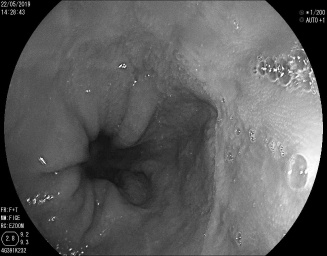

(512, 654, 1)


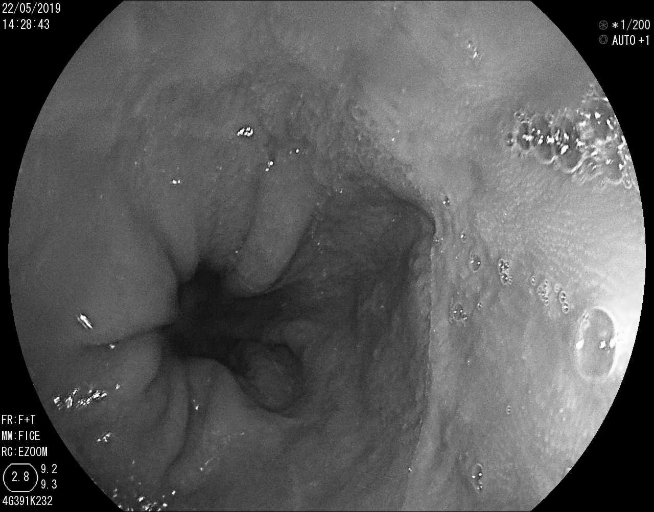

In [ ]:
for batch in train_ds.take(1):
    for img in batch[0]:
        print(img.shape)
        display(array_to_img(img))
        break
    for img in batch[1]:
        print(img.shape)
        display(array_to_img(img))
        break

In [ ]:
def upscale_image(model, img):
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32")/255.0
    input = np.expand_dims(y, axis=0)
    out = model.predict(input)
    out_img_y = out[0]
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img
def get_lowers_image(img, upscale_factor):
    return img.resize(
        (img.size[0]//upscale_factor, img.size[1]//upscale_factor),
        PIL.Image.BICUBIC)


In [ ]:
def get_model( channel_axis =1, nblocks=8, nlayers=8):
    def RDBlocks(input, i, nlayers):
        logits = Conv2D(filters=16, kernel_size=3, padding="same", activation="relu",
                    use_bias=True, name="conv2d_%d_%d" % (i+1, 0+1))(input)
        for j in range(1, nlayers):
            middle = Conv2D(filters=16, kernel_size=3, padding="same", activation="relu",
                            use_bias=True, name="conv2d_%d_%d" %(i+1, j+1))(logits)
            logits = concatenate([logits, middle], name="concatenate_%d_%d" % (i+1, j+1))
            return logits
    
    inp = keras.Input(shape = (None, None, channel_axis))
    x = layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same' , activation='relu', use_bias=True)(inp)
    G = x
    for i in range(nblocks):
        x = RDBlocks(x, i, nlayers)
        x = concatenate([x,G])
    
    # bottleneck layer
    x = layers.Conv2D(filters=256, kernel_size=1, padding='same', activation='relu', use_bias=True)(x)
    # deconvolution layers
    x = layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu', use_bias=True)(x)
    #x = layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', activation='relu', use_bias=True)(x)
    #x = layers.Conv2D(channel_axis*(2**2), kernel_size=3, padding='same', use_bias=True)(x)  
    #x = tf.nn.depth_to_space(x, 2)
    # reconstruction layer
    x = layers.Conv2D(filters = channel_axis, kernel_size=3, padding='same', use_bias=True)(x)
    return keras.Model(inp, x)

In [ ]:
def upscale_image(model, img):
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32")/255.0
    input = np.expand_dims(y, axis=0)
    out = model.predict(input)
    out_img_y = out[0]
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img

def get_lowers_image(img, upscale_factor):
    return img.resize(
        (img.size[0]//upscale_factor, img.size[1]//upscale_factor),
        PIL.Image.BICUBIC)

In [ ]:
test_path = '/content/drive/MyDrive/LAB Cô Hải/RDNSR/test/'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)
class RDNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(RDNCallback, self).__init__()
        self.test_img = get_lowers_image(load_img(test_img_paths[0]), upscale_factor)
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []
    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" %(np.mean(self.psnr)))
        if epoch%10 == 0:
            prediction = upscale_image(self.model, self.test_img)
    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10*math.log10(1/logs["loss"]))
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_filepath = "/content/tmp/checkpoint/"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = "loss",
    mode = "min",
    save_best_only = True,
)

In [ ]:
model = get_model()
#model.summary()
callbacks = [RDNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
epochs = 10
model.compile(
    optimizer=optimizer, loss=loss_fn, metrics=[SSIM]
)
H = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)
model.load_weights(checkpoint_filepath)

Epoch 1/10
Mean PSNR for epoch: 27.81
68/68 - 67s - loss: 0.0128 - SSIM: 0.9566 - val_loss: 0.0016 - val_SSIM: 0.9999 - 67s/epoch - 989ms/step
Epoch 2/10
Mean PSNR for epoch: 28.81
68/68 - 53s - loss: 0.0014 - SSIM: 0.9999 - val_loss: 0.0013 - val_SSIM: 0.9999 - 53s/epoch - 784ms/step
Epoch 3/10
Mean PSNR for epoch: 29.02
68/68 - 53s - loss: 0.0013 - SSIM: 0.9999 - val_loss: 0.0012 - val_SSIM: 0.9999 - 53s/epoch - 783ms/step
Epoch 4/10
Mean PSNR for epoch: 29.35
68/68 - 53s - loss: 0.0012 - SSIM: 0.9999 - val_loss: 0.0011 - val_SSIM: 0.9999 - 53s/epoch - 781ms/step
Epoch 5/10
Mean PSNR for epoch: 29.74
68/68 - 53s - loss: 0.0011 - SSIM: 0.9999 - val_loss: 0.0010 - val_SSIM: 0.9999 - 53s/epoch - 783ms/step
Epoch 6/10
Mean PSNR for epoch: 30.02
68/68 - 53s - loss: 0.0010 - SSIM: 0.9999 - val_loss: 9.7711e-04 - val_SSIM: 0.9999 - 53s/epoch - 782ms/step
Epoch 7/10
Mean PSNR for epoch: 30.22
68/68 - 53s - loss: 9.6508e-04 - SSIM: 0.9999 - val_loss: 9.4178e-04 - val_SSIM: 0.9998 - 53s/epoch 

In [ ]:

model.load_weights(checkpoint_filepath)

30.91597288193303


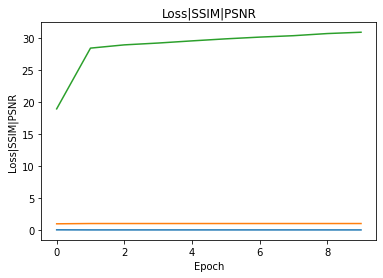

In [ ]:
PSNR = []
for x in H.history['loss']:
    PSNR.append(10*math.log10(1/x))
print(max(PSNR))
plt.plot(np.arange(0, epochs), H.history['loss'], label='training loss')
plt.plot(np.arange(0, epochs), H.history['SSIM'], label='training SSIM')
plt.plot(np.arange(0, epochs), PSNR, label='training PSNR')
plt.title('Loss|SSIM|PSNR')
plt.xlabel('Epoch')
plt.ylabel('Loss|SSIM|PSNR')

plt.show()

In [ ]:
i=0
names = os.listdir('/content/drive/MyDrive/LAB Cô Hải/RDNSR/test/')
test_path = '/content/drive/MyDrive/LAB Cô Hải/RDNSR/test/'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)
destination = '/content/drive/MyDrive/LAB Cô Hải/RDNSR/predict_demo/'
for index, test_img_path in enumerate(test_img_paths):
    img = load_img(test_img_path)
    lowers_input = get_lowers_image(img, upscale_factor)
    lowers_input.save(destination+names[i][:-4]+'_lower.jpg', "JPEG", quality=100, optimize=True, progressive=True)
    prediction = upscale_image(model, lowers_input)
    prediction.save(destination+names[i][:-4]+'_predict.jpg', "JPEG", quality=100, optimize=True, progressive=True)
    i += 1